## This notebook contains code to easily create the inputs required to run the process in one of the 'overlay' notebooks.

#### In addition to the outputs produced by this output, the user will need to also obtain from other sources elevation (NED DEM) and optionally ortho imagery data (NAIP).  

#### The final steps in the process is done in manually ArcScene outside of this notebook.  See instructions at the bottom of this notebook.

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

import rasterio

In [2]:
import sys
sys.path.append(r"..")
import phenocamomatic

sys.path.append(r"J:\Projects\NCCSC\phenocam\Tools\DaymetPy\daymetpy")
import daymetpy

# Create a point shapefile of our camera location

In [3]:
output_dir = r"J:\Projects\NCCSC\phenocam\DerivedData"
site_name = "harvard"

output_dir = os.path.join(output_dir, site_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [4]:
site = phenocamomatic.dataaccess.get_site(site_name)

In [5]:
site.x, site.y

(-72.1715, 42.5378)

In [6]:
import fiona
from fiona.crs import from_epsg
from shapely.geometry import Point, mapping

In [7]:
simpleschema = {'geometry': 'Point',
               'properties': {'name':'str'}}
shape_fname = os.path.join(output_dir, "ArcScene", "InputData", "wgs84","cameraloc.shp")
if not os.path.exists(os.path.split(shape_fname)[0]):
    os.makedirs(os.path.split(shape_fname)[0])


with fiona.open(shape_fname, 'w', crs=from_epsg(4326),driver='ESRI Shapefile', schema=simpleschema) as output:
    point = Point(site.x, site.y)
    output.write({'properties': {'name': site.sitename},'geometry': mapping(point)})

# Download the landsat8 scene over this area

In [8]:
from landsat.search import Search
from landsat.downloader import Downloader

In [9]:
s = Search()
results = s.search(lat=site.y, lon=site.x, limit=100)
scene_id = results['results'][0]['sceneID']

In [10]:
landsat_dname = os.path.join(output_dir, 'Landsat')
if not os.path.exists(landsat_dname):
    os.makedirs(landsat_dname)


In [29]:
from landsat.downloader import Downloader
outdir = os.path.join(output_dir, "Landsat")
d = Downloader(download_dir=outdir)
d.download([str(scene_id)], bands=[5, 4])

===> Source: AWS S3
===> Downloading: LC80120302015256LGN00_B5.TIF
     LC80120302015256LGN00_B5.TIF already exists on your system
     stored at J:/Projects/NCCSC/phenocam/DerivedData/harvard/Landsat/LC80120302015256LGN00
===> Downloading: LC80120302015256LGN00_B4.TIF
     LC80120302015256LGN00_B4.TIF already exists on your system
     stored at J:/Projects/NCCSC/phenocam/DerivedData/harvard/Landsat/LC80120302015256LGN00
===> Downloading: LC80120302015256LGN00_BQA.TIF
     LC80120302015256LGN00_BQA.TIF already exists on your system
     stored at J:/Projects/NCCSC/phenocam/DerivedData/harvard/Landsat/LC80120302015256LGN00
===> Downloading: LC80120302015256LGN00_MTL.txt
     LC80120302015256LGN00_MTL.txt already exists on your system
     stored at J:/Projects/NCCSC/phenocam/DerivedData/harvard/Landsat/LC80120302015256LGN00


['J:/Projects/NCCSC/phenocam/DerivedData/harvard/Landsat/LC80120302015256LGN00']

In [11]:
scene_dname = os.path.join(landsat_dname, scene_id)
scene_dname
b4_fname = os.path.join(scene_dname, [f for f in os.listdir(scene_dname) if f.endswith('_B4.TIF')][0])
b5_fname = os.path.join(scene_dname, [f for f in os.listdir(scene_dname) if f.endswith('_B5.TIF')][0])

In [12]:
print scene_dname

J:\Projects\NCCSC\phenocam\DerivedData\harvard\Landsat\LC80120302015256LGN00


In [13]:
landsat = rasterio.open(b5_fname)
landsat_data = landsat.read(masked=True)

img_extents = [landsat.bounds.left, landsat.bounds.right, landsat.bounds.bottom, landsat.bounds.top]

#### If the location isn't good (i.e. the red dot doesn't have landsat data around it) either get another landsat scene or mosaic a couple

C:\Anaconda\envs\phenocamomatic\lib\site-packages\matplotlib\artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


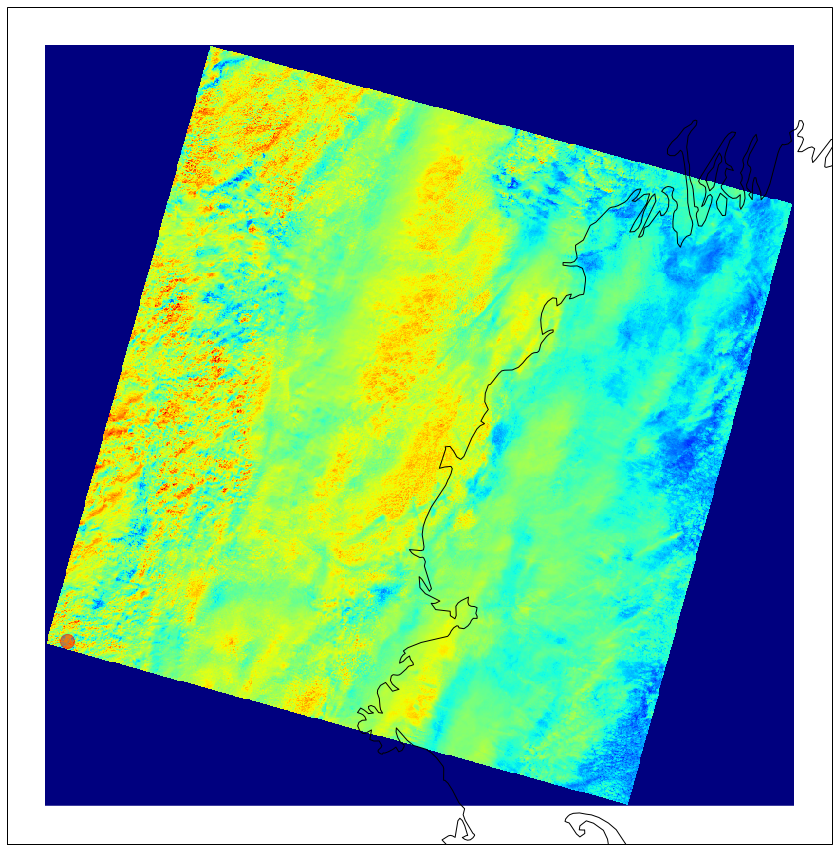

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

landsat_proj = ccrs.UTM(zone=int(landsat.crs_wkt.split("UTM zone ")[1].split('N')[0]), 
                        globe=ccrs.Globe(datum='WGS84', ellipse='WGS84'))
fig = plt.figure(figsize=(15, 15))
# ax_extent = [quickbird.x - 0.015, quickbird.x + 0.015, quickbird.y - 0.002, quickbird.y + 0.015]

img_extents = [landsat.bounds.left, landsat.bounds.right, landsat.bounds.bottom, landsat.bounds.top]

ax = plt.axes(projection=landsat_proj)
# ax.set_extent(ax_extent, ccrs.Geodetic())
ax.imshow(landsat_data[0, ::10, ::10], origin='upper', extent=img_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.jet)
ax.coastlines(resolution='10m')

geodetic = ccrs.Geodetic()
ax.scatter(site.x, site.y, color='r', s=200, alpha=0.5, transform=geodetic)

### We need to extract out a subset 254x254 centered horizontally on our camera loc, and extending north

In [15]:
camx, camy = list(landsat_proj.transform_point(site.x, site.y, geodetic))
camx, camy

(239555.506559328, 4714366.265093586)

In [16]:
a = landsat.affine

In [17]:
import math
cam_col, cam_row = [int(math.floor(coord)) for coord in ~a * (camx, camy)]
ulcol, lrcol = cam_col-254/2, cam_col+254/2
ulrow, lrrow = cam_row-250, cam_row+4

print cam_col, cam_row
print ulcol, ulrow
print lrcol, lrrow

235 6274
108 6024
362 6278


In [18]:
ulx,uly = a * (ulcol, ulrow)
lrx,lry = a * (lrcol, lrrow)

print ulx, uly
print lrx, lry

print camx, camy

235725.0 4721895.0
243345.0 4714275.0
239555.506559 4714366.26509


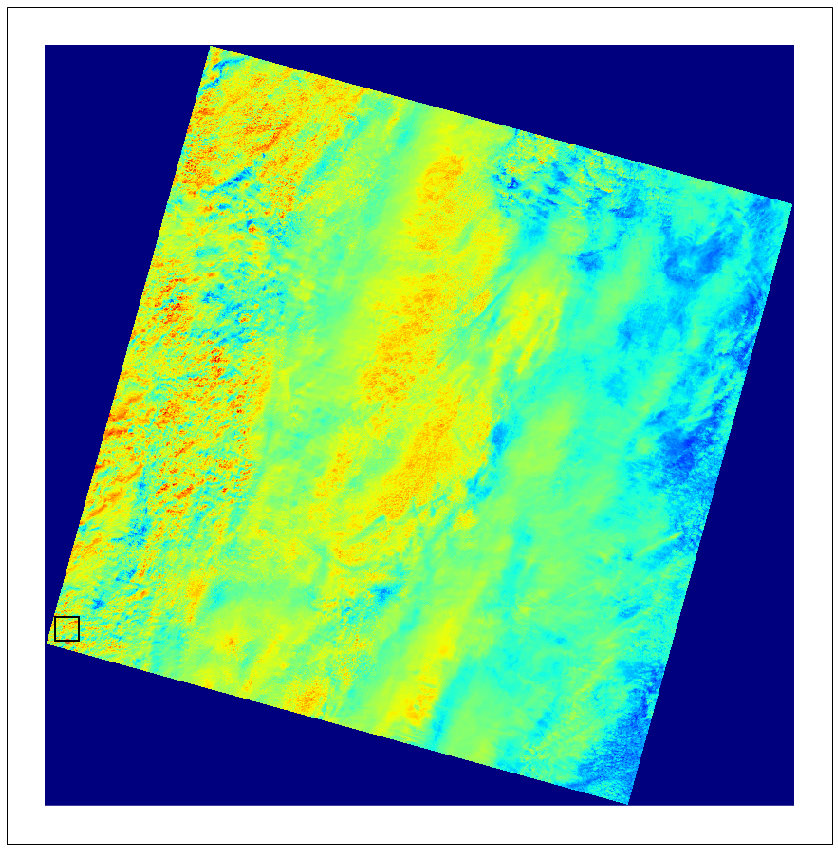

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=landsat_proj)
ax.imshow(landsat_data[0, ::10, ::10], origin='upper', extent=img_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.jet)

ax.scatter(site.x, site.y, color='r', s=20, alpha=0.5, transform=geodetic)

ax.plot([ulx,lrx], [uly, uly], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([ulx,lrx], [lry, lry], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([ulx,ulx], [uly, lry], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([lrx,lrx], [uly, lry], 'k-', lw=2, c='black', transform=landsat_proj)


In [20]:
from shapely.geometry import mapping, Polygon
import fiona

# Here's an example Shapely geometry
poly = Polygon([(ulx, uly), (lrx, uly), (lrx, lry), (ulx, lry), (ulx, uly)])

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
landsat_subset_dname = os.path.join(landsat_dname, 'Subset')
if not os.path.exists(landsat_subset_dname):
    os.makedirs(landsat_subset_dname)
    
boundary_fname = os.path.join(landsat_subset_dname, 'boundary.shp')
with fiona.open(boundary_fname, 'w', 'ESRI Shapefile', schema, crs=landsat.crs) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(poly),
        'properties': {'id': 123},
    })

In [21]:
from shapely.geometry import mapping, Polygon
import fiona

# Here's an example Shapely geometry
poly = Polygon([(ulx, uly), (lrx, uly), (lrx, lry), (ulx, lry), (ulx, uly)])

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'row': 'int', 'col':'int'},
}

# Write a new Shapefile
landsat_subset_dname = os.path.join(landsat_dname, 'Subset')
if not os.path.exists(landsat_subset_dname):
    os.makedirs(landsat_subset_dname)
    
fishnet_fname = os.path.join(landsat_subset_dname, 'fishnet.shp')
with fiona.open(fishnet_fname, 'w', 'ESRI Shapefile', schema, crs=landsat.crs) as c:
    ## If there are multiple geometries, put the "for" loop here
    for row in range(254):
        cell_uly = uly+(row*a.e)
        for col in range(254):
            cell_ulx = ulx+(col*landsat.affine.a)
            poly = Polygon([(cell_ulx, cell_uly), 
                            (cell_ulx + a.a, cell_uly), 
                            (cell_ulx + a.a, cell_uly+a.e), 
                            (cell_ulx, cell_uly+a.e), 
                            (cell_ulx, cell_uly)])
    
    
            c.write({
                'geometry': mapping(poly),
                'properties': {'row': row,
                              'col':col},
            })

# Create a subset of this for display purposes

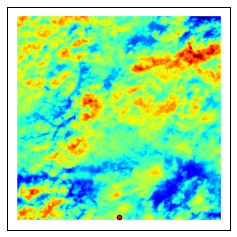

In [55]:
subset = landsat_data[0, ulrow:lrrow, ulcol:lrcol]

plt.imshow(subset)
plt.scatter(cam_col-ulcol, cam_row-ulrow, c='r')
phenocamomatic.plotting.format_photo_axes(plt.gca())

In [56]:
subset_fname = os.path.join(landsat_subset_dname, "subset2.tif")

import copy
subset_meta = copy.copy(landsat.meta)
subset_meta['width'] = subset.shape[0]
subset_meta['height'] = subset.shape[1]

new_transform = list(landsat.meta['transform'])
new_transform[0] = ulx
new_transform[3] = uly
subset_meta['transform'] = tuple(new_transform)
import affine
subset_meta['affine'] = affine.Affine.from_gdal(*subset_meta['transform'])
with rasterio.open(subset_fname, 'w', **subset_meta) as dst:
    dst.write_band(1, subset.astype(rasterio.uint16))


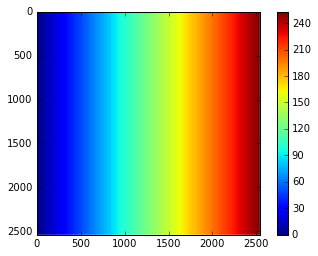

In [57]:
%matplotlib inline
n=10
r = np.zeros(subset.shape).astype(np.dtype('i1'))
col_x3 = np.tile(np.repeat(np.arange(r.shape[1]), n), (r.shape[0])*n)
col_x3.shape = r.shape[0]*n, r.shape[1]*n

col_x3test = col_x3.copy()
col_x3test[col_x3test % 2 != 0] = 255 - col_x3test[col_x3test % 2 != 0]

plt.imshow(col_x3, interpolation='none')
plt.colorbar()


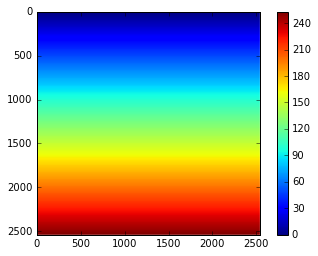

In [58]:
row_x3 = np.tile(np.repeat(np.arange(r.shape[0]), n), (r.shape[1]*n))
row_x3.shape = r.shape[1]*n, r.shape[0]*n
row_x3 = row_x3.T

row_x3test = row_x3.copy()
row_x3test[row_x3test % 2 != 0] = 255 - row_x3test[row_x3test % 2 != 0]

plt.imshow(row_x3, interpolation='none')
plt.colorbar()


In [59]:
b = np.zeros(row_x3.shape)

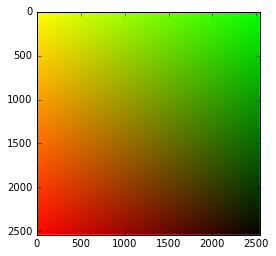

In [60]:
%matplotlib inline
plt.imshow(np.dstack([col_x3, row_x3, b])[:,:,:], interpolation='none')


##### One small detail to note, because of the way ArcScene renders a raster, we're increasing the resoultion 10x

In [61]:
import scipy
subset_index_fname = os.path.join(landsat_subset_dname, "subset_index.tif")

import copy
subset_meta = copy.copy(landsat.meta)
subset_meta['width'] = subset.shape[0] * 10
subset_meta['height'] = subset.shape[1] * 10

new_transform = list(landsat.meta['transform'])
new_transform[0] = ulx
new_transform[3] = uly
new_transform[1] = new_transform[1] / 10.0
new_transform[-1] = new_transform[-1] / 10.0
subset_meta['transform'] = new_transform

import affine
subset_meta['affine'] = affine.Affine.from_gdal(*subset_meta['transform'])

subset_meta.update(
    dtype=rasterio.uint8,
    count=3,
    nodata=255)

with rasterio.open(subset_index_fname, 'w', **subset_meta) as dst:
    dst.write_band(1, col_x3.astype(rasterio.uint8))
    dst.write_band(2, row_x3.astype(rasterio.uint8))
    dst.write_band(3, b.astype(rasterio.uint8))

## Now download and process some NED 30m DEM data for our area

In [1]:
from ulmo.usgs.ned import core
core.get_available_layers()

['1 arc-second', '1/9 arc-second', 'Alaska 2 arc-second', '1/3 arc-second']

In [3]:
import os
import ulmo
print(ulmo.util.get_ulmo_dir())

layer = '1/3 arc-second'
bbox = [-100, 35, -100.05, 35.05]
dname = r"C:\temp\test"
if not os.path.exists(dname):
    os.makedirs(dname)
    
result = core.get_raster(layer=layer, bbox=bbox, path=dname, mosaic=True)

C:\Users\talbertc\AppData\Local\ulmo\ulmo
retrieving raster availability from https://www.sciencebase.gov/catalog/items?fields=webLinks,spatial,title&q=&filter=tags=National Elevation Dataset (NED) 1/3 arc-second&filter=tags=IMG&filter=spatialQuery=Polygon ((-100.0 35.05,-100.0 35.0,-100.05 35.0,-100.05 35.05,-100.0 35.05))&format=json&max=1000
... downloading tile 1 of 1 from https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/n36w100.zip
... ... zipfile saved at C:\temp\test\13\zip\n36w100.zip
... ... .img format raster saved at C:\temp\test\13\n36w100.img
... downloading tile 1 of 1 from https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/n35w100.zip
... ... zipfile saved at C:\temp\test\13\zip\n35w100.zip
... ... .img format raster saved at C:\temp\test\13\n35w100.img
... downloading tile 1 of 1 from https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/n36w101.zip
... ... zipfile saved at C:\temp\test\13\zip\n36w101.zip
... ... .img format rast

CalledProcessError: Command '['gdalwarp', '-overwrite', '-te', '-100.0', '35.0', '-100.05', '35.05', 'C:\\temp\\test\\by_boundingbox\\e21886d4ed548753bfdb70ad3027e03b.vrt', 'C:\\temp\\test\\by_boundingbox\\e21886d4ed548753bfdb70ad3027e03b.tif']' returned non-zero exit status 1

In [44]:
layer = '1/3 arc-second'
bbox = list(geodetic.transform_point(ulx, lry, landsat_proj))
bbox += list(geodetic.transform_point(lrx, uly, landsat_proj))
dname = os.path.join(output_dir, "ArcScene", "InputData", "DEM")
if not os.path.exists(dname):
    os.makedirs(dname)
    
result = core.get_raster(layer=layer, bbox=bbox, path=dname, mosaic=True)

retrieving raster availability from https://www.sciencebase.gov/catalog/items?fields=webLinks,spatial,title&q=&filter=tags=National Elevation Dataset (NED) 1/3 arc-second&filter=tags=IMG&filter=spatialQuery=Polygon ((-72.21803184921511 42.606768110588405,-72.21803184921511 42.535679614116454,-72.12880716007643 42.535679614116454,-72.12880716007643 42.606768110588405,-72.21803184921511 42.606768110588405))&format=json&max=1000
... downloading tile 1 of 1 from https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/USGS_NED_13_n43w073_IMG.zip
... ... zipfile saved at J:\Projects\NCCSC\phenocam\DerivedData\harvard\ArcScene\InputData\DEM\13\zip\USGS_NED_13_n43w073_IMG.zip
... ... .img format raster saved at J:\Projects\NCCSC\phenocam\DerivedData\harvard\ArcScene\InputData\DEM\13\USGS_NED_13_n43w073_IMG.img


### Reproject this to match our landsat subset grid

In [1]:
dem = rasterio.open(result)
subset = rasterio.open(subset_fname)

NameError: name 'rasterio' is not defined

In [64]:
from rasterio.warp import calculate_default_transform, reproject, RESAMPLING

out_fname = os.path.join(dname, os.path.split(result[0])[1].replace('.tif', '_utm.tif'))

# affine, width, height = calculate_default_transform(
#     src.crs, dst_crs, src.width, src.height, *src.bounds)
kwargs = subset.meta.copy()
kwargs['dtype'] = dem.meta['dtype']
kwargs['nodata'] = dem.meta['nodata']
# kwargs.update({
#         'crs': subset.crs,
#         'transform': subset.affine,
#         'affine': subset.affine,
#         'width': subset.width,
#         'height': subset.height
#     })

with rasterio.open(out_fname, 'w', **kwargs) as dst:
    reproject(
        source=rasterio.band(dem, 1),
        destination=rasterio.band(dst, 1),
        src_transform=dem.affine,
        src_crs=dem.crs,
        dst_transform=subset.affine,
        dst_crs=subset.crs,
        resampling=RESAMPLING.cubic_spline)

    

    dem_data = dst.read_band(1, masked=True)   


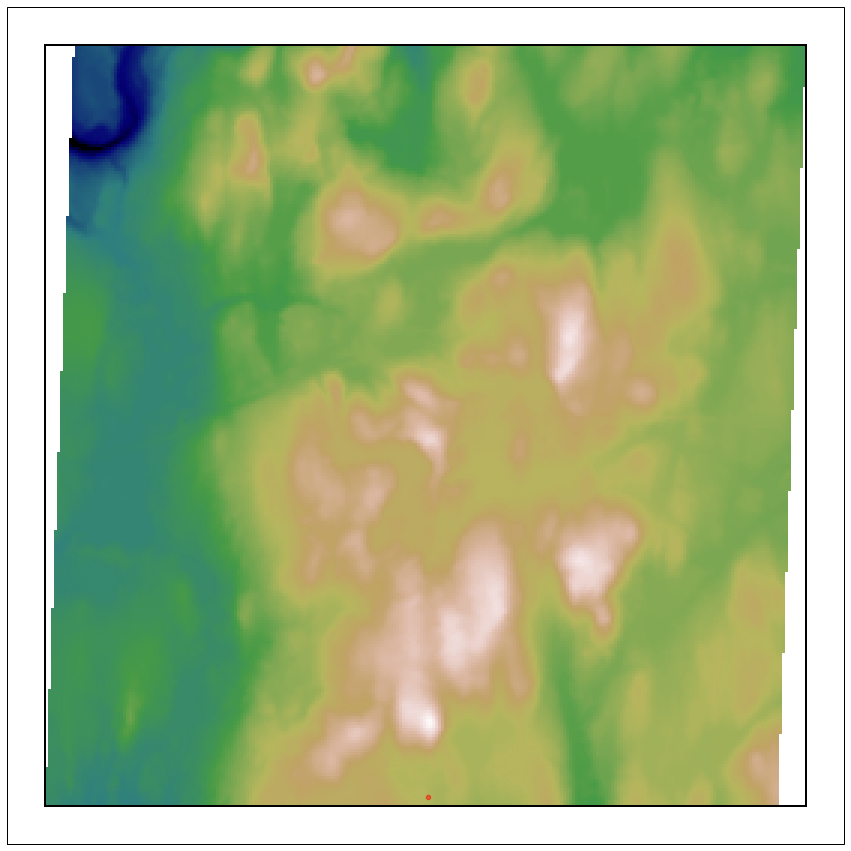

In [66]:
elev_subset_fname = out_fname
elev = rasterio.open(elev_subset_fname)
elev_data = elev.read()

nad83 = ccrs.Geodetic(globe=ccrs.Globe(datum='NAD83', ellipse='GRS80'))
# %matplotlib inline
# plt.imshow(landsat_data[0,:,:], interpolation='none')



elev_extents = [elev.bounds.left, elev.bounds.right, elev.bounds.bottom, elev.bounds.top]


fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=landsat_proj)
ax.imshow(dem_data, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none')

ax.scatter(site.x, site.y, color='r', s=20, alpha=0.5, transform=geodetic)

ax.plot([ulx,lrx], [uly, uly], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([ulx,lrx], [lry, lry], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([ulx,ulx], [uly, lry], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([lrx,lrx], [uly, lry], 'k-', lw=2, c='black', transform=landsat_proj)

Now open arcscene and bring in the subset_index.tif, fishnet.shp, and cameraloc.shp files
Then create an elevation grid (30m dem) that matches the landsat grid, and maybe an ortho photo of the area as well (NAIP)

use the elevation grid to set the base heights of all
extrude the camera loc point to create a visual pole

Navigate to the camera location and orient the scene manually to recreate the phenocam photo view.  This can be a bit fiddly.
Change the display of the fishnet.shp to have white squares and red outlines. turn off shadows.
Export this scene to 2d. (..\ArcScene\red_gridlines.bmp)
Change the display of the subset_index.tif to have a raster resolution of 3 in the base heights screen and stretch = None and turn off the apply gamma stretch check box in symbology.
Export this scene to 2d. (..\ArcScene\IndexGrid_final.bmp)


### Get a sample of modis data to cover our area

In [68]:
import pymodis

In [35]:
pymodis.downmodis

In [69]:
pymodis.

<module 'pymodis' from 'C:\Anaconda\envs\phenocamomatic\lib\site-packages\pymodis\__init__.pyc'>

In [70]:
import pandas as pd

In [85]:
pd.read_table("http://modis-land.gsfc.nasa.gov/pdf/sn_bound_10deg.txt", skiprows=17, skipfooter=13)

C:\Anaconda\envs\phenocamomatic\lib\site-packages\ipykernel\__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


Error: new-line character seen in unquoted field - do you need to open the file in universal-newline mode?

In [89]:

url="http://landweb.nascom.nasa.gov/developers/sn_tiles/sn_gring_10deg.txt"
s=requests.get(url).content
c=pd.read_csv('\n'.join(io.StringIO(s.decode('utf-8')).read().splitlines()))

IOError: File Sinusoidal Grid
 Bounding Coordinates of MODLAND Tiles

 ntile_vert = 18
 ntile_horiz = 36

 iv  ih    lon_min    lon_max   lat_min   lat_max
  0   0  -999.0000  -999.0000  -99.0000  -99.0000
  0   1  -999.0000  -999.0000  -99.0000  -99.0000
  0   2  -999.0000  -999.0000  -99.0000  -99.0000
  0   3  -999.0000  -999.0000  -99.0000  -99.0000
  0   4  -999.0000  -999.0000  -99.0000  -99.0000
  0   5  -999.0000  -999.0000  -99.0000  -99.0000
  0   6  -999.0000  -999.0000  -99.0000  -99.0000
  0   7  -999.0000  -999.0000  -99.0000  -99.0000
  0   8  -999.0000  -999.0000  -99.0000  -99.0000
  0   9  -999.0000  -999.0000  -99.0000  -99.0000
  0  10  -999.0000  -999.0000  -99.0000  -99.0000
  0  11  -999.0000  -999.0000  -99.0000  -99.0000
  0  12  -999.0000  -999.0000  -99.0000  -99.0000
  0  13  -999.0000  -999.0000  -99.0000  -99.0000
  0  14  -180.0000  -172.7151   80.0000   80.4083
  0  15  -180.0000  -115.1274   80.0000   83.6250
  0  16  -180.0000   -57.5397   80.0000   86.8167
  0  17  -180.0000    57.2957   80.0000   90.0000
  0  18    -0.0040   180.0000   80.0000   90.0000
  0  19    57.5877   180.0000   80.0000   86.8167
  0  20   115.1754   180.0000   80.0000   83.6250
  0  21   172.7631   180.0000   80.0000   80.4083
  0  22  -999.0000  -999.0000  -99.0000  -99.0000
  0  23  -999.0000  -999.0000  -99.0000  -99.0000
  0  24  -999.0000  -999.0000  -99.0000  -99.0000
  0  25  -999.0000  -999.0000  -99.0000  -99.0000
  0  26  -999.0000  -999.0000  -99.0000  -99.0000
  0  27  -999.0000  -999.0000  -99.0000  -99.0000
  0  28  -999.0000  -999.0000  -99.0000  -99.0000
  0  29  -999.0000  -999.0000  -99.0000  -99.0000
  0  30  -999.0000  -999.0000  -99.0000  -99.0000
  0  31  -999.0000  -999.0000  -99.0000  -99.0000
  0  32  -999.0000  -999.0000  -99.0000  -99.0000
  0  33  -999.0000  -999.0000  -99.0000  -99.0000
  0  34  -999.0000  -999.0000  -99.0000  -99.0000
  0  35  -999.0000  -999.0000  -99.0000  -99.0000
  1   0  -999.0000  -999.0000  -99.0000  -99.0000
  1   1  -999.0000  -999.0000  -99.0000  -99.0000
  1   2  -999.0000  -999.0000  -99.0000  -99.0000
  1   3  -999.0000  -999.0000  -99.0000  -99.0000
  1   4  -999.0000  -999.0000  -99.0000  -99.0000
  1   5  -999.0000  -999.0000  -99.0000  -99.0000
  1   6  -999.0000  -999.0000  -99.0000  -99.0000
  1   7  -999.0000  -999.0000  -99.0000  -99.0000
  1   8  -999.0000  -999.0000  -99.0000  -99.0000
  1   9  -999.0000  -999.0000  -99.0000  -99.0000
  1  10  -999.0000  -999.0000  -99.0000  -99.0000
  1  11  -180.0000  -175.4039   70.0000   70.5333
  1  12  -180.0000  -146.1659   70.0000   73.8750
  1  13  -180.0000  -116.9278   70.0000   77.1667
  1  14  -180.0000   -87.6898   70.0000   80.0000
  1  15  -172.7631   -58.4517   70.0000   80.0000
  1  16  -115.1754   -29.2137   70.0000   80.0000
  1  17   -57.5877     0.0480   70.0000   80.0000
  1  18     0.0000    57.6357   70.0000   80.0000
  1  19    29.2380   115.2234   70.0000   80.0000
  1  20    58.4761   172.8111   70.0000   80.0000
  1  21    87.7141   180.0000   70.0000   80.0000
  1  22   116.9522   180.0000   70.0000   77.1583
  1  23   146.1902   180.0000   70.0000   73.8750
  1  24   175.4283   180.0000   70.0000   70.5333
  1  25  -999.0000  -999.0000  -99.0000  -99.0000
  1  26  -999.0000  -999.0000  -99.0000  -99.0000
  1  27  -999.0000  -999.0000  -99.0000  -99.0000
  1  28  -999.0000  -999.0000  -99.0000  -99.0000
  1  29  -999.0000  -999.0000  -99.0000  -99.0000
  1  30  -999.0000  -999.0000  -99.0000  -99.0000
  1  31  -999.0000  -999.0000  -99.0000  -99.0000
  1  32  -999.0000  -999.0000  -99.0000  -99.0000
  1  33  -999.0000  -999.0000  -99.0000  -99.0000
  1  34  -999.0000  -999.0000  -99.0000  -99.0000
  1  35  -999.0000  -999.0000  -99.0000  -99.0000
  2   0  -999.0000  -999.0000  -99.0000  -99.0000
  2   1  -999.0000  -999.0000  -99.0000  -99.0000
  2   2  -999.0000  -999.0000  -99.0000  -99.0000
  2   3  -999.0000  -999.0000  -99.0000  -99.0000
  2   4  -999.0000  -999.0000  -99.0000  -99.0000
  2   5  -999.0000  -999.0000  -99.0000  -99.0000
  2   6  -999.0000  -999.0000  -99.0000  -99.0000
  2   7  -999.0000  -999.0000  -99.0000  -99.0000
  2   8  -999.0000  -999.0000  -99.0000  -99.0000
  2   9  -180.0000  -159.9833   60.0000   63.6167
  2  10  -180.0000  -139.9833   60.0000   67.1167
  2  11  -180.0000  -119.9833   60.0000   70.0000
  2  12  -175.4283   -99.9833   60.0000   70.0000
  2  13  -146.1902   -79.9833   60.0000   70.0000
  2  14  -116.9522   -59.9833   60.0000   70.0000
  2  15   -87.7141   -39.9833   60.0000   70.0000
  2  16   -58.4761   -19.9833   60.0000   70.0000
  2  17   -29.2380     0.0244   60.0000   70.0000
  2  18     0.0000    29.2624   60.0000   70.0000
  2  19    20.0000    58.5005   60.0000   70.0000
  2  20    40.0000    87.7385   60.0000   70.0000
  2  21    60.0000   116.9765   60.0000   70.0000
  2  22    80.0000   146.2146   60.0000   70.0000
  2  23   100.0000   175.4526   60.0000   70.0000
  2  24   120.0000   180.0000   60.0000   70.0000
  2  25   140.0000   180.0000   60.0000   67.1167
  2  26   160.0000   180.0000   60.0000   63.6167
  2  27  -999.0000  -999.0000  -99.0000  -99.0000
  2  28  -999.0000  -999.0000  -99.0000  -99.0000
  2  29  -999.0000  -999.0000  -99.0000  -99.0000
  2  30  -999.0000  -999.0000  -99.0000  -99.0000
  2  31  -999.0000  -999.0000  -99.0000  -99.0000
  2  32  -999.0000  -999.0000  -99.0000  -99.0000
  2  33  -999.0000  -999.0000  -99.0000  -99.0000
  2  34  -999.0000  -999.0000  -99.0000  -99.0000
  2  35  -999.0000  -999.0000  -99.0000  -99.0000
  3   0  -999.0000  -999.0000  -99.0000  -99.0000
  3   1  -999.0000  -999.0000  -99.0000  -99.0000
  3   2  -999.0000  -999.0000  -99.0000  -99.0000
  3   3  -999.0000  -999.0000  -99.0000  -99.0000
  3   4  -999.0000  -999.0000  -99.0000  -99.0000
  3   5  -999.0000  -999.0000  -99.0000  -99.0000
  3   6  -180.0000  -171.1167   50.0000   52.3333
  3   7  -180.0000  -155.5594   50.0000   56.2583
  3   8  -180.0000  -140.0022   50.0000   60.0000
  3   9  -180.0000  -124.4449   50.0000   60.0000
  3  10  -160.0000  -108.8877   50.0000   60.0000
  3  11  -140.0000   -93.3305   50.0000   60.0000
  3  12  -120.0000   -77.7732   50.0000   60.0000
  3  13  -100.0000   -62.2160   50.0000   60.0000
  3  14   -80.0000   -46.6588   50.0000   60.0000
  3  15   -60.0000   -31.1015   50.0000   60.0000
  3  16   -40.0000   -15.5443   50.0000   60.0000
  3  17   -20.0000     0.0167   50.0000   60.0000
  3  18     0.0000    20.0167   50.0000   60.0000
  3  19    15.5572    40.0167   50.0000   60.0000
  3  20    31.1145    60.0167   50.0000   60.0000
  3  21    46.6717    80.0167   50.0000   60.0000
  3  22    62.2290   100.0167   50.0000   60.0000
  3  23    77.7862   120.0167   50.0000   60.0000
  3  24    93.3434   140.0167   50.0000   60.0000
  3  25   108.9007   160.0167   50.0000   60.0000
  3  26   124.4579   180.0000   50.0000   60.0000
  3  27   140.0151   180.0000   50.0000   60.0000
  3  28   155.5724   180.0000   50.0000   56.2500
  3  29   171.1296   180.0000   50.0000   52.3333
  3  30  -999.0000  -999.0000  -99.0000  -99.0000
  3  31  -999.0000  -999.0000  -99.0000  -99.0000
  3  32  -999.0000  -999.0000  -99.0000  -99.0000
  3  33  -999.0000  -999.0000  -99.0000  -99.0000
  3  34  -999.0000  -999.0000  -99.0000  -99.0000
  3  35  -999.0000  -999.0000  -99.0000  -99.0000
  4   0  -999.0000  -999.0000  -99.0000  -99.0000
  4   1  -999.0000  -999.0000  -99.0000  -99.0000
  4   2  -999.0000  -999.0000  -99.0000  -99.0000
  4   3  -999.0000  -999.0000  -99.0000  -99.0000
  4   4  -180.0000  -169.6921   40.0000   43.7667
  4   5  -180.0000  -156.6380   40.0000   48.1917
  4   6  -180.0000  -143.5839   40.0000   50.0000
  4   7  -171.1296  -130.5299   40.0000   50.0000
  4   8  -155.5724  -117.4758   40.0000   50.0000
  4   9  -140.0151  -104.4217   40.0000   50.0000
  4  10  -124.4579   -91.3676   40.0000   50.0000
  4  11  -108.9007   -78.3136   40.0000   50.0000
  4  12   -93.3434   -65.2595   40.0000   50.0000
  4  13   -77.7862   -52.2054   40.0000   50.0000
  4  14   -62.2290   -39.1513   40.0000   50.0000
  4  15   -46.6717   -26.0973   40.0000   50.0000
  4  16   -31.1145   -13.0432   40.0000   50.0000
  4  17   -15.5572     0.0130   40.0000   50.0000
  4  18     0.0000    15.5702   40.0000   50.0000
  4  19    13.0541    31.1274   40.0000   50.0000
  4  20    26.1081    46.6847   40.0000   50.0000
  4  21    39.1622    62.2419   40.0000   50.0000
  4  22    52.2163    77.7992   40.0000   50.0000
  4  23    65.2704    93.3564   40.0000   50.0000
  4  24    78.3244   108.9136   40.0000   50.0000
  4  25    91.3785   124.4709   40.0000   50.0000
  4  26   104.4326   140.0281   40.0000   50.0000
  4  27   117.4867   155.5853   40.0000   50.0000
  4  28   130.5407   171.1426   40.0000   50.0000
  4  29   143.5948   180.0000   40.0000   50.0000
  4  30   156.6489   180.0000   40.0000   48.1917
  4  31   169.7029   180.0000   40.0000   43.7583
  4  32  -999.0000  -999.0000  -99.0000  -99.0000
  4  33  -999.0000  -999.0000  -99.0000  -99.0000
  4  34  -999.0000  -999.0000  -99.0000  -99.0000
  4  35  -999.0000  -999.0000  -99.0000  -99.0000
  5   0  -999.0000  -999.0000  -99.0000  -99.0000
  5   1  -999.0000  -999.0000  -99.0000  -99.0000
  5   2  -180.0000  -173.1955   30.0000   33.5583
  5   3  -180.0000  -161.6485   30.0000   38.9500
  5   4  -180.0000  -150.1014   30.0000   40.0000
  5   5  -169.7029  -138.5544   30.0000   40.0000
  5   6  -156.6489  -127.0074   30.0000   40.0000
  5   7  -143.5948  -115.4604   30.0000   40.0000
  5   8  -130.5407  -103.9134   30.0000   40.0000
  5   9  -117.4867   -92.3664   30.0000   40.0000
  5  10  -104.4326   -80.8194   30.0000   40.0000
  5  11   -91.3785   -69.2724   30.0000   40.0000
  5  12   -78.3244   -57.7254   30.0000   40.0000
  5  13   -65.2704   -46.1784   30.0000   40.0000
  5  14   -52.2163   -34.6314   30.0000   40.0000
  5  15   -39.1622   -23.0844   30.0000   40.0000
  5  16   -26.1081   -11.5374   30.0000   40.0000
  5  17   -13.0541     0.0109   30.0000   40.0000
  5  18     0.0000    13.0650   30.0000   40.0000
  5  19    11.5470    26.1190   30.0000   40.0000
  5  20    23.0940    39.1731   30.0000   40.0000
  5  21    34.6410    52.2272   30.0000   40.0000
  5  22    46.1880    65.2812   30.0000   40.0000
  5  23    57.7350    78.3353   30.0000   40.0000
  5  24    69.2820    91.3894   30.0000   40.0000
  5  25    80.8290   104.4435   30.0000   40.0000
  5  26    92.3760   117.4975   30.0000   40.0000
  5  27   103.9230   130.5516   30.0000   40.0000
  5  28   115.4701   143.6057   30.0000   40.0000
  5  29   127.0171   156.6598   30.0000   40.0000
  5  30   138.5641   169.7138   30.0000   40.0000
  5  31   150.1111   180.0000   30.0000   40.0000
  5  32   161.6581   180.0000   30.0000   38.9417
  5  33   173.2051   180.0000   30.0000   33.5583
  5  34  -999.0000  -999.0000  -99.0000  -99.0000
  5  35  -999.0000  -999.0000  -99.0000  -99.0000
  6   0  -999.0000  -999.0000  -99.0000  -99.0000
  6   1  -180.0000  -170.2596   20.0000   27.2667
  6   2  -180.0000  -159.6178   20.0000   30.0000
  6   3  -173.2051  -148.9760   20.0000   30.0000
  6   4  -161.6581  -138.3342   20.0000   30.0000
  6   5  -150.1111  -127.6925   20.0000   30.0000
  6   6  -138.5641  -117.0507   20.0000   30.0000
  6   7  -127.0171  -106.4089   20.0000   30.0000
  6   8  -115.4701   -95.7671   20.0000   30.0000
  6   9  -103.9230   -85.1254   20.0000   30.0000
  6  10   -92.3760   -74.4836   20.0000   30.0000
  6  11   -80.8290   -63.8418   20.0000   30.0000
  6  12   -69.2820   -53.2000   20.0000   30.0000
  6  13   -57.7350   -42.5582   20.0000   30.0000
  6  14   -46.1880   -31.9165   20.0000   30.0000
  6  15   -34.6410   -21.2747   20.0000   30.0000
  6  16   -23.0940   -10.6329   20.0000   30.0000
  6  17   -11.5470     0.0096   20.0000   30.0000
  6  18     0.0000    11.5566   20.0000   30.0000
  6  19    10.6418    23.1036   20.0000   30.0000
  6  20    21.2836    34.6506   20.0000   30.0000
  6  21    31.9253    46.1976   20.0000   30.0000
  6  22    42.5671    57.7446   20.0000   30.0000
  6  23    53.2089    69.2917   20.0000   30.0000
  6  24    63.8507    80.8387   20.0000   30.0000
  6  25    74.4924    92.3857   20.0000   30.0000
  6  26    85.1342   103.9327   20.0000   30.0000
  6  27    95.7760   115.4797   20.0000   30.0000
  6  28   106.4178   127.0267   20.0000   30.0000
  6  29   117.0596   138.5737   20.0000   30.0000
  6  30   127.7013   150.1207   20.0000   30.0000
  6  31   138.3431   161.6677   20.0000   30.0000
  6  32   148.9849   173.2147   20.0000   30.0000
  6  33   159.6267   180.0000   20.0000   30.0000
  6  34   170.2684   180.0000   20.0000   27.2667
  6  35  -999.0000  -999.0000  -99.0000  -99.0000
  7   0  -180.0000  -172.6141   10.0000   19.1917
  7   1  -180.0000  -162.4598   10.0000   20.0000
  7   2  -170.2684  -152.3055   10.0000   20.0000
  7   3  -159.6267  -142.1513   10.0000   20.0000
  7   4  -148.9849  -131.9970   10.0000   20.0000
  7   5  -138.3431  -121.8427   10.0000   20.0000
  7   6  -127.7013  -111.6885   10.0000   20.0000
  7   7  -117.0596  -101.5342   10.0000   20.0000
  7   8  -106.4178   -91.3799   10.0000   20.0000
  7   9   -95.7760   -81.2257   10.0000   20.0000
  7  10   -85.1342   -71.0714   10.0000   20.0000
  7  11   -74.4924   -60.9171   10.0000   20.0000
  7  12   -63.8507   -50.7629   10.0000   20.0000
  7  13   -53.2089   -40.6086   10.0000   20.0000
  7  14   -42.5671   -30.4543   10.0000   20.0000
  7  15   -31.9253   -20.3001   10.0000   20.0000
  7  16   -21.2836   -10.1458   10.0000   20.0000
  7  17   -10.6418     0.0089   10.0000   20.0000
  7  18     0.0000    10.6506   10.0000   20.0000
  7  19    10.1543    21.2924   10.0000   20.0000
  7  20    20.3085    31.9342   10.0000   20.0000
  7  21    30.4628    42.5760   10.0000   20.0000
  7  22    40.6171    53.2178   10.0000   20.0000
  7  23    50.7713    63.8595   10.0000   20.0000
  7  24    60.9256    74.5013   10.0000   20.0000
  7  25    71.0799    85.1431   10.0000   20.0000
  7  26    81.2341    95.7849   10.0000   20.0000
  7  27    91.3884   106.4266   10.0000   20.0000
  7  28   101.5427   117.0684   10.0000   20.0000
  7  29   111.6969   127.7102   10.0000   20.0000
  7  30   121.8512   138.3520   10.0000   20.0000
  7  31   132.0055   148.9938   10.0000   20.0000
  7  32   142.1597   159.6355   10.0000   20.0000
  7  33   152.3140   170.2773   10.0000   20.0000
  7  34   162.4683   180.0000   10.0000   20.0000
  7  35   172.6225   180.0000   10.0000   19.1833
  8   0  -180.0000  -169.9917   -0.0000   10.0000
  8   1  -172.6225  -159.9917   -0.0000   10.0000
  8   2  -162.4683  -149.9917   -0.0000   10.0000
  8   3  -152.3140  -139.9917   -0.0000   10.0000
  8   4  -142.1597  -129.9917   -0.0000   10.0000
  8   5  -132.0055  -119.9917   -0.0000   10.0000
  8   6  -121.8512  -109.9917   -0.0000   10.0000
  8   7  -111.6969   -99.9917   -0.0000   10.0000
  8   8  -101.5427   -89.9917   -0.0000   10.0000
  8   9   -91.3884   -79.9917   -0.0000   10.0000
  8  10   -81.2341   -69.9917   -0.0000   10.0000
  8  11   -71.0799   -59.9917   -0.0000   10.0000
  8  12   -60.9256   -49.9917   -0.0000   10.0000
  8  13   -50.7713   -39.9917   -0.0000   10.0000
  8  14   -40.6171   -29.9917   -0.0000   10.0000
  8  15   -30.4628   -19.9917   -0.0000   10.0000
  8  16   -20.3085    -9.9917   -0.0000   10.0000
  8  17   -10.1543     0.0085   -0.0000   10.0000
  8  18     0.0000    10.1627   -0.0000   10.0000
  8  19    10.0000    20.3170   -0.0000   10.0000
  8  20    20.0000    30.4713   -0.0000   10.0000
  8  21    30.0000    40.6255   -0.0000   10.0000
  8  22    40.0000    50.7798   -0.0000   10.0000
  8  23    50.0000    60.9341   -0.0000   10.0000
  8  24    60.0000    71.0883   -0.0000   10.0000
  8  25    70.0000    81.2426   -0.0000   10.0000
  8  26    80.0000    91.3969   -0.0000   10.0000
  8  27    90.0000   101.5511   -0.0000   10.0000
  8  28   100.0000   111.7054   -0.0000   10.0000
  8  29   110.0000   121.8597   -0.0000   10.0000
  8  30   120.0000   132.0139   -0.0000   10.0000
  8  31   130.0000   142.1682   -0.0000   10.0000
  8  32   140.0000   152.3225   -0.0000   10.0000
  8  33   150.0000   162.4767   -0.0000   10.0000
  8  34   160.0000   172.6310   -0.0000   10.0000
  8  35   170.0000   180.0000   -0.0000   10.0000
  9   0  -180.0000  -169.9917  -10.0000   -0.0000
  9   1  -172.6225  -159.9917  -10.0000   -0.0000
  9   2  -162.4683  -149.9917  -10.0000   -0.0000
  9   3  -152.3140  -139.9917  -10.0000   -0.0000
  9   4  -142.1597  -129.9917  -10.0000   -0.0000
  9   5  -132.0055  -119.9917  -10.0000   -0.0000
  9   6  -121.8512  -109.9917  -10.0000   -0.0000
  9   7  -111.6969   -99.9917  -10.0000   -0.0000
  9   8  -101.5427   -89.9917  -10.0000   -0.0000
  9   9   -91.3884   -79.9917  -10.0000   -0.0000
  9  10   -81.2341   -69.9917  -10.0000   -0.0000
  9  11   -71.0799   -59.9917  -10.0000   -0.0000
  9  12   -60.9256   -49.9917  -10.0000   -0.0000
  9  13   -50.7713   -39.9917  -10.0000   -0.0000
  9  14   -40.6171   -29.9917  -10.0000   -0.0000
  9  15   -30.4628   -19.9917  -10.0000   -0.0000
  9  16   -20.3085    -9.9917  -10.0000   -0.0000
  9  17   -10.1543     0.0085  -10.0000   -0.0000
  9  18     0.0000    10.1627  -10.0000   -0.0000
  9  19    10.0000    20.3170  -10.0000   -0.0000
  9  20    20.0000    30.4713  -10.0000   -0.0000
  9  21    30.0000    40.6255  -10.0000   -0.0000
  9  22    40.0000    50.7798  -10.0000   -0.0000
  9  23    50.0000    60.9341  -10.0000   -0.0000
  9  24    60.0000    71.0883  -10.0000   -0.0000
  9  25    70.0000    81.2426  -10.0000   -0.0000
  9  26    80.0000    91.3969  -10.0000   -0.0000
  9  27    90.0000   101.5511  -10.0000   -0.0000
  9  28   100.0000   111.7054  -10.0000   -0.0000
  9  29   110.0000   121.8597  -10.0000   -0.0000
  9  30   120.0000   132.0139  -10.0000   -0.0000
  9  31   130.0000   142.1682  -10.0000   -0.0000
  9  32   140.0000   152.3225  -10.0000   -0.0000
  9  33   150.0000   162.4767  -10.0000   -0.0000
  9  34   160.0000   172.6310  -10.0000   -0.0000
  9  35   170.0000   180.0000  -10.0000   -0.0000
 10   0  -180.0000  -172.6141  -19.1917  -10.0000
 10   1  -180.0000  -162.4598  -20.0000  -10.0000
 10   2  -170.2684  -152.3055  -20.0000  -10.0000
 10   3  -159.6267  -142.1513  -20.0000  -10.0000
 10   4  -148.9849  -131.9970  -20.0000  -10.0000
 10   5  -138.3431  -121.8427  -20.0000  -10.0000
 10   6  -127.7013  -111.6885  -20.0000  -10.0000
 10   7  -117.0596  -101.5342  -20.0000  -10.0000
 10   8  -106.4178   -91.3799  -20.0000  -10.0000
 10   9   -95.7760   -81.2257  -20.0000  -10.0000
 10  10   -85.1342   -71.0714  -20.0000  -10.0000
 10  11   -74.4924   -60.9171  -20.0000  -10.0000
 10  12   -63.8507   -50.7629  -20.0000  -10.0000
 10  13   -53.2089   -40.6086  -20.0000  -10.0000
 10  14   -42.5671   -30.4543  -20.0000  -10.0000
 10  15   -31.9253   -20.3001  -20.0000  -10.0000
 10  16   -21.2836   -10.1458  -20.0000  -10.0000
 10  17   -10.6418     0.0089  -20.0000  -10.0000
 10  18     0.0000    10.6506  -20.0000  -10.0000
 10  19    10.1543    21.2924  -20.0000  -10.0000
 10  20    20.3085    31.9342  -20.0000  -10.0000
 10  21    30.4628    42.5760  -20.0000  -10.0000
 10  22    40.6171    53.2178  -20.0000  -10.0000
 10  23    50.7713    63.8595  -20.0000  -10.0000
 10  24    60.9256    74.5013  -20.0000  -10.0000
 10  25    71.0799    85.1431  -20.0000  -10.0000
 10  26    81.2341    95.7849  -20.0000  -10.0000
 10  27    91.3884   106.4266  -20.0000  -10.0000
 10  28   101.5427   117.0684  -20.0000  -10.0000
 10  29   111.6969   127.7102  -20.0000  -10.0000
 10  30   121.8512   138.3520  -20.0000  -10.0000
 10  31   132.0055   148.9938  -20.0000  -10.0000
 10  32   142.1597   159.6355  -20.0000  -10.0000
 10  33   152.3140   170.2773  -20.0000  -10.0000
 10  34   162.4683   180.0000  -20.0000  -10.0000
 10  35   172.6225   180.0000  -19.1833  -10.0000
 11   0  -999.0000  -999.0000  -99.0000  -99.0000
 11   1  -180.0000  -170.2596  -27.2667  -20.0000
 11   2  -180.0000  -159.6178  -30.0000  -20.0000
 11   3  -173.2051  -148.9760  -30.0000  -20.0000
 11   4  -161.6581  -138.3342  -30.0000  -20.0000
 11   5  -150.1111  -127.6925  -30.0000  -20.0000
 11   6  -138.5641  -117.0507  -30.0000  -20.0000
 11   7  -127.0171  -106.4089  -30.0000  -20.0000
 11   8  -115.4701   -95.7671  -30.0000  -20.0000
 11   9  -103.9230   -85.1254  -30.0000  -20.0000
 11  10   -92.3760   -74.4836  -30.0000  -20.0000
 11  11   -80.8290   -63.8418  -30.0000  -20.0000
 11  12   -69.2820   -53.2000  -30.0000  -20.0000
 11  13   -57.7350   -42.5582  -30.0000  -20.0000
 11  14   -46.1880   -31.9165  -30.0000  -20.0000
 11  15   -34.6410   -21.2747  -30.0000  -20.0000
 11  16   -23.0940   -10.6329  -30.0000  -20.0000
 11  17   -11.5470     0.0096  -30.0000  -20.0000
 11  18     0.0000    11.5566  -30.0000  -20.0000
 11  19    10.6418    23.1036  -30.0000  -20.0000
 11  20    21.2836    34.6506  -30.0000  -20.0000
 11  21    31.9253    46.1976  -30.0000  -20.0000
 11  22    42.5671    57.7446  -30.0000  -20.0000
 11  23    53.2089    69.2917  -30.0000  -20.0000
 11  24    63.8507    80.8387  -30.0000  -20.0000
 11  25    74.4924    92.3857  -30.0000  -20.0000
 11  26    85.1342   103.9327  -30.0000  -20.0000
 11  27    95.7760   115.4797  -30.0000  -20.0000
 11  28   106.4178   127.0267  -30.0000  -20.0000
 11  29   117.0596   138.5737  -30.0000  -20.0000
 11  30   127.7013   150.1207  -30.0000  -20.0000
 11  31   138.3431   161.6677  -30.0000  -20.0000
 11  32   148.9849   173.2147  -30.0000  -20.0000
 11  33   159.6267   180.0000  -30.0000  -20.0000
 11  34   170.2684   180.0000  -27.2667  -20.0000
 11  35  -999.0000  -999.0000  -99.0000  -99.0000
 12   0  -999.0000  -999.0000  -99.0000  -99.0000
 12   1  -999.0000  -999.0000  -99.0000  -99.0000
 12   2  -180.0000  -173.1955  -33.5583  -30.0000
 12   3  -180.0000  -161.6485  -38.9500  -30.0000
 12   4  -180.0000  -150.1014  -40.0000  -30.0000
 12   5  -169.7029  -138.5544  -40.0000  -30.0000
 12   6  -156.6489  -127.0074  -40.0000  -30.0000
 12   7  -143.5948  -115.4604  -40.0000  -30.0000
 12   8  -130.5407  -103.9134  -40.0000  -30.0000
 12   9  -117.4867   -92.3664  -40.0000  -30.0000
 12  10  -104.4326   -80.8194  -40.0000  -30.0000
 12  11   -91.3785   -69.2724  -40.0000  -30.0000
 12  12   -78.3244   -57.7254  -40.0000  -30.0000
 12  13   -65.2704   -46.1784  -40.0000  -30.0000
 12  14   -52.2163   -34.6314  -40.0000  -30.0000
 12  15   -39.1622   -23.0844  -40.0000  -30.0000
 12  16   -26.1081   -11.5374  -40.0000  -30.0000
 12  17   -13.0541     0.0109  -40.0000  -30.0000
 12  18     0.0000    13.0650  -40.0000  -30.0000
 12  19    11.5470    26.1190  -40.0000  -30.0000
 12  20    23.0940    39.1731  -40.0000  -30.0000
 12  21    34.6410    52.2272  -40.0000  -30.0000
 12  22    46.1880    65.2812  -40.0000  -30.0000
 12  23    57.7350    78.3353  -40.0000  -30.0000
 12  24    69.2820    91.3894  -40.0000  -30.0000
 12  25    80.8290   104.4435  -40.0000  -30.0000
 12  26    92.3760   117.4975  -40.0000  -30.0000
 12  27   103.9230   130.5516  -40.0000  -30.0000
 12  28   115.4701   143.6057  -40.0000  -30.0000
 12  29   127.0171   156.6598  -40.0000  -30.0000
 12  30   138.5641   169.7138  -40.0000  -30.0000
 12  31   150.1111   180.0000  -40.0000  -30.0000
 12  32   161.6581   180.0000  -38.9417  -30.0000
 12  33   173.2051   180.0000  -33.5583  -30.0000
 12  34  -999.0000  -999.0000  -99.0000  -99.0000
 12  35  -999.0000  -999.0000  -99.0000  -99.0000
 13   0  -999.0000  -999.0000  -99.0000  -99.0000
 13   1  -999.0000  -999.0000  -99.0000  -99.0000
 13   2  -999.0000  -999.0000  -99.0000  -99.0000
 13   3  -999.0000  -999.0000  -99.0000  -99.0000
 13   4  -180.0000  -169.6921  -43.7667  -40.0000
 13   5  -180.0000  -156.6380  -48.1917  -40.0000
 13   6  -180.0000  -143.5839  -50.0000  -40.0000
 13   7  -171.1296  -130.5299  -50.0000  -40.0000
 13   8  -155.5724  -117.4758  -50.0000  -40.0000
 13   9  -140.0151  -104.4217  -50.0000  -40.0000
 13  10  -124.4579   -91.3676  -50.0000  -40.0000
 13  11  -108.9007   -78.3136  -50.0000  -40.0000
 13  12   -93.3434   -65.2595  -50.0000  -40.0000
 13  13   -77.7862   -52.2054  -50.0000  -40.0000
 13  14   -62.2290   -39.1513  -50.0000  -40.0000
 13  15   -46.6717   -26.0973  -50.0000  -40.0000
 13  16   -31.1145   -13.0432  -50.0000  -40.0000
 13  17   -15.5572     0.0130  -50.0000  -40.0000
 13  18     0.0000    15.5702  -50.0000  -40.0000
 13  19    13.0541    31.1274  -50.0000  -40.0000
 13  20    26.1081    46.6847  -50.0000  -40.0000
 13  21    39.1622    62.2419  -50.0000  -40.0000
 13  22    52.2163    77.7992  -50.0000  -40.0000
 13  23    65.2704    93.3564  -50.0000  -40.0000
 13  24    78.3244   108.9136  -50.0000  -40.0000
 13  25    91.3785   124.4709  -50.0000  -40.0000
 13  26   104.4326   140.0281  -50.0000  -40.0000
 13  27   117.4867   155.5853  -50.0000  -40.0000
 13  28   130.5407   171.1426  -50.0000  -40.0000
 13  29   143.5948   180.0000  -50.0000  -40.0000
 13  30   156.6489   180.0000  -48.1917  -40.0000
 13  31   169.7029   180.0000  -43.7583  -40.0000
 13  32  -999.0000  -999.0000  -99.0000  -99.0000
 13  33  -999.0000  -999.0000  -99.0000  -99.0000
 13  34  -999.0000  -999.0000  -99.0000  -99.0000
 13  35  -999.0000  -999.0000  -99.0000  -99.0000
 14   0  -999.0000  -999.0000  -99.0000  -99.0000
 14   1  -999.0000  -999.0000  -99.0000  -99.0000
 14   2  -999.0000  -999.0000  -99.0000  -99.0000
 14   3  -999.0000  -999.0000  -99.0000  -99.0000
 14   4  -999.0000  -999.0000  -99.0000  -99.0000
 14   5  -999.0000  -999.0000  -99.0000  -99.0000
 14   6  -180.0000  -171.1167  -52.3333  -50.0000
 14   7  -180.0000  -155.5594  -56.2583  -50.0000
 14   8  -180.0000  -140.0022  -60.0000  -50.0000
 14   9  -180.0000  -124.4449  -60.0000  -50.0000
 14  10  -160.0000  -108.8877  -60.0000  -50.0000
 14  11  -140.0000   -93.3305  -60.0000  -50.0000
 14  12  -120.0000   -77.7732  -60.0000  -50.0000
 14  13  -100.0000   -62.2160  -60.0000  -50.0000
 14  14   -80.0000   -46.6588  -60.0000  -50.0000
 14  15   -60.0000   -31.1015  -60.0000  -50.0000
 14  16   -40.0000   -15.5443  -60.0000  -50.0000
 14  17   -20.0000     0.0167  -60.0000  -50.0000
 14  18     0.0000    20.0167  -60.0000  -50.0000
 14  19    15.5572    40.0167  -60.0000  -50.0000
 14  20    31.1145    60.0167  -60.0000  -50.0000
 14  21    46.6717    80.0167  -60.0000  -50.0000
 14  22    62.2290   100.0167  -60.0000  -50.0000
 14  23    77.7862   120.0167  -60.0000  -50.0000
 14  24    93.3434   140.0167  -60.0000  -50.0000
 14  25   108.9007   160.0167  -60.0000  -50.0000
 14  26   124.4579   180.0000  -60.0000  -50.0000
 14  27   140.0151   180.0000  -60.0000  -50.0000
 14  28   155.5724   180.0000  -56.2500  -50.0000
 14  29   171.1296   180.0000  -52.3333  -50.0000
 14  30  -999.0000  -999.0000  -99.0000  -99.0000
 14  31  -999.0000  -999.0000  -99.0000  -99.0000
 14  32  -999.0000  -999.0000  -99.0000  -99.0000
 14  33  -999.0000  -999.0000  -99.0000  -99.0000
 14  34  -999.0000  -999.0000  -99.0000  -99.0000
 14  35  -999.0000  -999.0000  -99.0000  -99.0000
 15   0  -999.0000  -999.0000  -99.0000  -99.0000
 15   1  -999.0000  -999.0000  -99.0000  -99.0000
 15   2  -999.0000  -999.0000  -99.0000  -99.0000
 15   3  -999.0000  -999.0000  -99.0000  -99.0000
 15   4  -999.0000  -999.0000  -99.0000  -99.0000
 15   5  -999.0000  -999.0000  -99.0000  -99.0000
 15   6  -999.0000  -999.0000  -99.0000  -99.0000
 15   7  -999.0000  -999.0000  -99.0000  -99.0000
 15   8  -999.0000  -999.0000  -99.0000  -99.0000
 15   9  -180.0000  -159.9833  -63.6167  -60.0000
 15  10  -180.0000  -139.9833  -67.1167  -60.0000
 15  11  -180.0000  -119.9833  -70.0000  -60.0000
 15  12  -175.4283   -99.9833  -70.0000  -60.0000
 15  13  -146.1902   -79.9833  -70.0000  -60.0000
 15  14  -116.9522   -59.9833  -70.0000  -60.0000
 15  15   -87.7141   -39.9833  -70.0000  -60.0000
 15  16   -58.4761   -19.9833  -70.0000  -60.0000
 15  17   -29.2380     0.0244  -70.0000  -60.0000
 15  18     0.0000    29.2624  -70.0000  -60.0000
 15  19    20.0000    58.5005  -70.0000  -60.0000
 15  20    40.0000    87.7385  -70.0000  -60.0000
 15  21    60.0000   116.9765  -70.0000  -60.0000
 15  22    80.0000   146.2146  -70.0000  -60.0000
 15  23   100.0000   175.4526  -70.0000  -60.0000
 15  24   120.0000   180.0000  -70.0000  -60.0000
 15  25   140.0000   180.0000  -67.1167  -60.0000
 15  26   160.0000   180.0000  -63.6167  -60.0000
 15  27  -999.0000  -999.0000  -99.0000  -99.0000
 15  28  -999.0000  -999.0000  -99.0000  -99.0000
 15  29  -999.0000  -999.0000  -99.0000  -99.0000
 15  30  -999.0000  -999.0000  -99.0000  -99.0000
 15  31  -999.0000  -999.0000  -99.0000  -99.0000
 15  32  -999.0000  -999.0000  -99.0000  -99.0000
 15  33  -999.0000  -999.0000  -99.0000  -99.0000
 15  34  -999.0000  -999.0000  -99.0000  -99.0000
 15  35  -999.0000  -999.0000  -99.0000  -99.0000
 16   0  -999.0000  -999.0000  -99.0000  -99.0000
 16   1  -999.0000  -999.0000  -99.0000  -99.0000
 16   2  -999.0000  -999.0000  -99.0000  -99.0000
 16   3  -999.0000  -999.0000  -99.0000  -99.0000
 16   4  -999.0000  -999.0000  -99.0000  -99.0000
 16   5  -999.0000  -999.0000  -99.0000  -99.0000
 16   6  -999.0000  -999.0000  -99.0000  -99.0000
 16   7  -999.0000  -999.0000  -99.0000  -99.0000
 16   8  -999.0000  -999.0000  -99.0000  -99.0000
 16   9  -999.0000  -999.0000  -99.0000  -99.0000
 16  10  -999.0000  -999.0000  -99.0000  -99.0000
 16  11  -180.0000  -175.4039  -70.5333  -70.0000
 16  12  -180.0000  -146.1659  -73.8750  -70.0000
 16  13  -180.0000  -116.9278  -77.1667  -70.0000
 16  14  -180.0000   -87.6898  -80.0000  -70.0000
 16  15  -172.7631   -58.4517  -80.0000  -70.0000
 16  16  -115.1754   -29.2137  -80.0000  -70.0000
 16  17   -57.5877     0.0480  -80.0000  -70.0000
 16  18     0.0000    57.6357  -80.0000  -70.0000
 16  19    29.2380   115.2234  -80.0000  -70.0000
 16  20    58.4761   172.8111  -80.0000  -70.0000
 16  21    87.7141   180.0000  -80.0000  -70.0000
 16  22   116.9522   180.0000  -77.1583  -70.0000
 16  23   146.1902   180.0000  -73.8750  -70.0000
 16  24   175.4283   180.0000  -70.5333  -70.0000
 16  25  -999.0000  -999.0000  -99.0000  -99.0000
 16  26  -999.0000  -999.0000  -99.0000  -99.0000
 16  27  -999.0000  -999.0000  -99.0000  -99.0000
 16  28  -999.0000  -999.0000  -99.0000  -99.0000
 16  29  -999.0000  -999.0000  -99.0000  -99.0000
 16  30  -999.0000  -999.0000  -99.0000  -99.0000
 16  31  -999.0000  -999.0000  -99.0000  -99.0000
 16  32  -999.0000  -999.0000  -99.0000  -99.0000
 16  33  -999.0000  -999.0000  -99.0000  -99.0000
 16  34  -999.0000  -999.0000  -99.0000  -99.0000
 16  35  -999.0000  -999.0000  -99.0000  -99.0000
 17   0  -999.0000  -999.0000  -99.0000  -99.0000
 17   1  -999.0000  -999.0000  -99.0000  -99.0000
 17   2  -999.0000  -999.0000  -99.0000  -99.0000
 17   3  -999.0000  -999.0000  -99.0000  -99.0000
 17   4  -999.0000  -999.0000  -99.0000  -99.0000
 17   5  -999.0000  -999.0000  -99.0000  -99.0000
 17   6  -999.0000  -999.0000  -99.0000  -99.0000
 17   7  -999.0000  -999.0000  -99.0000  -99.0000
 17   8  -999.0000  -999.0000  -99.0000  -99.0000
 17   9  -999.0000  -999.0000  -99.0000  -99.0000
 17  10  -999.0000  -999.0000  -99.0000  -99.0000
 17  11  -999.0000  -999.0000  -99.0000  -99.0000
 17  12  -999.0000  -999.0000  -99.0000  -99.0000
 17  13  -999.0000  -999.0000  -99.0000  -99.0000
 17  14  -180.0000  -172.7151  -80.4083  -80.0000
 17  15  -180.0000  -115.1274  -83.6250  -80.0000
 17  16  -180.0000   -57.5397  -86.8167  -80.0000
 17  17  -180.0000    57.2957  -90.0000  -80.0000
 17  18    -0.0040   180.0000  -90.0000  -80.0000
 17  19    57.5877   180.0000  -86.8167  -80.0000
 17  20   115.1754   180.0000  -83.6250  -80.0000
 17  21   172.7631   180.0000  -80.4083  -80.0000
 17  22  -999.0000  -999.0000  -99.0000  -99.0000
 17  23  -999.0000  -999.0000  -99.0000  -99.0000
 17  24  -999.0000  -999.0000  -99.0000  -99.0000
 17  25  -999.0000  -999.0000  -99.0000  -99.0000
 17  26  -999.0000  -999.0000  -99.0000  -99.0000
 17  27  -999.0000  -999.0000  -99.0000  -99.0000
 17  28  -999.0000  -999.0000  -99.0000  -99.0000
 17  29  -999.0000  -999.0000  -99.0000  -99.0000
 17  30  -999.0000  -999.0000  -99.0000  -99.0000
 17  31  -999.0000  -999.0000  -99.0000  -99.0000
 17  32  -999.0000  -999.0000  -99.0000  -99.0000
 17  33  -999.0000  -999.0000  -99.0000  -99.0000
 17  34  -999.0000  -999.0000  -99.0000  -99.0000
 17  35  -999.0000  -999.0000  -99.0000  -99.0000

 ntile = 648  nfill = 188  nnonfill = 460 does not exist

In [3]:
import pandas as pd
import io
import requests

import shapely

import sys
if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO
from pandas import DataFrame

url="http://landweb.nascom.nasa.gov/developers/sn_tiles/sn_gring_10deg.txt"
s=requests.get(url).content
contents = '\n'.join(io.StringIO(s.decode('utf-8')).read().splitlines()[7:-2])
hv_lookup = pd.read_csv(StringIO(contents), sep=r"\s+", parse_dates=False, 
                        na_values=[-99.0, -999.0], 
                        names = ['v', 'h', 'll_lon', 'll_lat', 'ul_lon', 'ul_lat', 'ur_lon', 'ur_lat', 'lr_lon', 'lr_lat'])


In [4]:
hv_lookup

,v,h,ll_lon,ll_lat,ul_lon,ul_lat,ur_lon,ur_lat,lr_lon,lr_lat
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import cartopy
modis = cartopy.crs.Sinusoidal.MODIS
geodetic = cartopy.crs.Geodetic()

lon = -109.0
lat = 35.0

def get_modis(lon, lat):
    return list(modis.transform_point(lon, lat, geodetic))

In [40]:
%matplotlib qt4
from matplotlib import pyplot
from descartes.patch import PolygonPatch

fig = pyplot.figure(1, figsize=(12,12), dpi=90)
ax = fig.add_subplot(111)

ax_ll_lon, _ = get_modis(-180, 0)
ax_ur_lon, _ = get_modis(180, 0)
_, ax_ll_lat = get_modis(0, -90)
_, ax_ur_lat = get_modis(0, 90)

tile_width = (ax_ur_lon - ax_ll_lon)/36
tile_height = (ax_ur_lat - ax_ll_lat)/18

ax.set_xlim((ax_ll_lon, ax_ur_lon))
ax.set_ylim((ax_ll_lat, ax_ur_lat))

for h in range(36):
    left_lon = ax_ll_lon + (tile_width*h)
    right_lon = left_lon + tile_width
    for v in range(18):
        top_lat = ax_ur_lat - (tile_height*v)
        bottom_lat = top_lat - tile_height
        
        poly = shapely.geometry.Polygon([(left_lon, top_lat),
                             (right_lon, top_lat),
                             (right_lon, bottom_lat),
                             (left_lon, bottom_lat),
                             (left_lon, top_lat),])
        patch = PolygonPatch(poly, facecolor='red', edgecolor='w', alpha=0.5, zorder=2)
        ax.add_patch(patch)
        
        ax.text((right_lon+left_lon)/2, (top_lat+bottom_lat)/2, '{} {}'.format(h, v))


# for row_i in range(hv_lookup.shape[0]-100):
#     try:
#         row = hv_lookup.loc[row_i]
#         if pd.notnull(hv_lookup.loc[row_i].ll_lon):

#             ll_lon, ll_lat = get_modis(row['ll_lon'], row['ll_lat'])
#             lr_lon, lr_lat = get_modis(row['lr_lon'], row['lr_lat'])
#             ul_lon, ul_lat = get_modis(row['ul_lon'], row['ul_lat'])
#             ur_lon, ur_lat = get_modis(row['ur_lon'], row['ur_lat'])


#     #         print ll_lon, ll_lat, ur_lat, ur_lon
#     #         if ll_lon > -170 and lr_lon < 170 and \
#     #             ul_lon > -170 and ur_lon < 170:


#             poly = shapely.geometry.Polygon([(ll_lon, ll_lat),
#                              (lr_lon, lr_lat),
#                              (ur_lon, ur_lat),
#                              (ul_lon, ul_lat),
#                              (ll_lon, ll_lat),])
#             patch = PolygonPatch(poly, facecolor='red', edgecolor='w', alpha=0.1, zorder=2)
#             ax.add_patch(patch)
            
        
# #         print "g"
#     except ValueError:
#         print ".",
#         pass

In [36]:
(ax_ur_lon - ax_ll_lon)/36

1111950.5197665233

In [11]:
row['ll_lon']

50.575200000000002

(-90.0, 90.0)

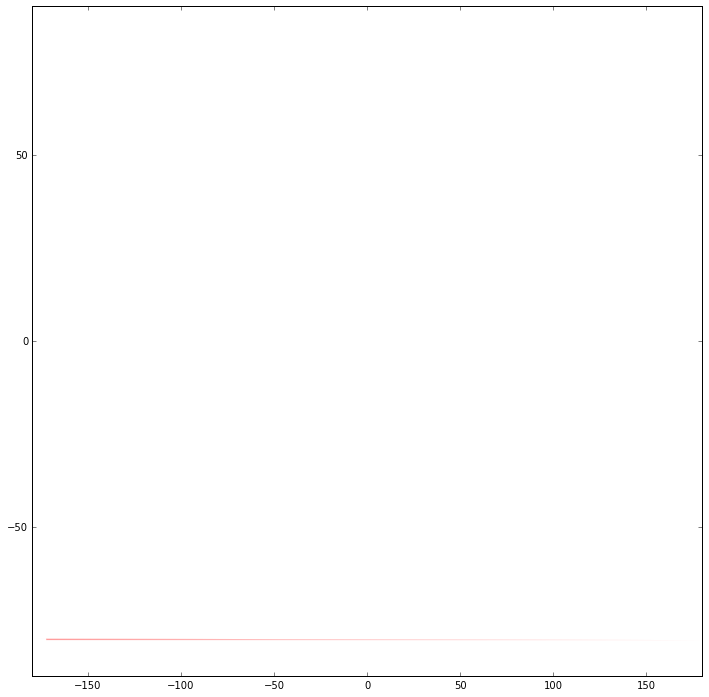

In [198]:
%matplotlib inline
row = hv_lookup.loc[626]
poly = shapely.geometry.Polygon([(row['ll_lon'], row['ll_lat']),
                         (row['lr_lon'], row['lr_lat']),
                         (row['ur_lon'], row['ur_lat']),
                         (row['ul_lon'], row['ul_lat']),
                         (row['ll_lon'], row['ll_lat']),])

fig = pyplot.figure(1, figsize=(12,12), dpi=90)
ax = fig.add_subplot(111)

patch = PolygonPatch(poly, facecolor='red', edgecolor='w', alpha=0.5, zorder=2)
ax.add_patch(patch)
ax.set_xlim((-180.0, 180.0))
ax.set_ylim((-90.0, 90.0))

In [174]:
hv_lookup

,v,h,ll_lon,ll_lat,ul_lon,ul_lat,ur_lon,ur_lat,lr_lon,lr_lat
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def get_hv(lat, lon):
    """returns the horizontal and vertical index of a modis tile
    cooresponding to a passed latitude and longitude
    """
    

In [129]:
lon = -109.0
lat = 35.0

In [134]:
lon_rows = hv_lookup[(hv_lookup.lon_min<=lon) & (hv_lookup.lon_max>=lon) & (hv_lookup.lat_min<=lat) & (hv_lookup.lat_max>=lat)]
lon_rows

,iv,ih,lon_min,lon_max,lat_min,lat_max
188,5,8,-130.5407,-103.9134,30.0,40.0
189,5,9,-117.4867,-92.3664,30.0,40.0


In [21]:
pd.notnull(hv_lookup.loc[14].ll_lon)

True

In [31]:
get_modis(-180, 0)

[-20015109.355797417, 0.0]

In [42]:
import pygaarst

In [43]:
from pygaarst import modapsclient as m
a = m.ModapsClient()

In [45]:
a.getDataLayers('MOD13Q1')

{u'MOD13Q1___250m 16 days EVI': u'250m 16 days EVI',
 u'MOD13Q1___250m 16 days MIR reflectance': u'250m 16 days MIR reflectance',
 u'MOD13Q1___250m 16 days NDVI': u'250m 16 days NDVI',
 u'MOD13Q1___250m 16 days NIR reflectance': u'250m 16 days NIR reflectance',
 u'MOD13Q1___250m 16 days VI Quality': u'250m 16 days VI Quality',
 u'MOD13Q1___250m 16 days blue reflectance': u'250m 16 days blue reflectance',
 u'MOD13Q1___250m 16 days composite day of the year': u'250m 16 days composite day of the year',
 u'MOD13Q1___250m 16 days pixel reliability': u'250m 16 days pixel reliability',
 u'MOD13Q1___250m 16 days red reflectance': u'250m 16 days red reflectance',
 u'MOD13Q1___250m 16 days relative azimuth angle': u'250m 16 days relative azimuth angle',
 u'MOD13Q1___250m 16 days sun zenith angle': u'250m 16 days sun zenith angle',
 u'MOD13Q1___250m 16 days view zenith angle': u'250m 16 days view zenith angle'}

In [1]:
import pymodis

GDAL installation has no support for HDF4, please update GDAL
WxPython missing, no GUI enabled


In [6]:
# destination foldert
dest = r"C:\temp_colin\downloads\tilemap3_r4_0"
# tiles to download
tiles = "h18v04,h19v04"
# starting day
day = "2014-08-14"
# number of day to download
delta = 16

In [7]:
modisDown = pymodis.downmodis.downModis(destinationFolder=dest, tiles=tiles, today=day, delta=delta)
modisDown.connect()

In [8]:
print dest

C:\temp_colin\downloads\tilemap3_r4_0


In [10]:
from osgeo import gdal

In [11]:
gdal.GetDriverByName('HDF5')

<osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x000000000AB8DB40> >

In [12]:
gdal.GetDriverByName('HDF4')